In [1]:
!pip install torchsummary

****Importing Libraries****

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Hyperparameters & paths
FRAME_INTERVAL = 30
RESOLUTION      = 64
BATCH_SIZE      = 512
NUM_EPOCHS      = 10
LEARNING_RATE   = 1e-3

In [5]:
CLASS_PATHS = {
    "Abuse": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Abuse",
    "Arrest": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arrest",
    "Arson": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arson",
    "Assault": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Assault",
    "Burglary": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary",
    "Explosion": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Explosion",
    "Fighting": "/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Fighting",
}

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((RESOLUTION, RESOLUTION)),
])

In [7]:
class CrimeFrameDataset(Dataset):
    def __init__(self, train=True, split=0.8, seed=42):
        torch.manual_seed(seed)
        self.frames, self.labels = [], []
        p_incl = split if train else 1 - split

        for label, folder in CLASS_PATHS.items():
            for fname in os.listdir(folder):
                if fname.endswith(".mp4") and torch.rand(1).item() <= p_incl:
                    path = os.path.join(folder, fname)
                    self._load_video(path, label)

        print(f"{'Train' if train else 'Test'} frames: {len(self.frames)}")

    def _load_video(self, path, label):
        cap = cv2.VideoCapture(path)
        idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if idx % FRAME_INTERVAL == 0:
                yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
                y   = yuv[:, :, 0]
                self.frames.append(transform(y))
                self.labels.append(label)
            idx += 1
        cap.release()

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, i):
        lbl = list(CLASS_PATHS).index(self.labels[i])
        return self.frames[i], torch.tensor(lbl, dtype=torch.long)

# Create loaders
train_ds = CrimeFrameDataset(train=True)
test_ds  = CrimeFrameDataset(train=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


Train frames: 51896
Test frames: 16243


In [8]:
# Cell: Visualization Helpers
import matplotlib.pyplot as plt

def plot_frames(frames, labels, grid=(5,5)):
    """
    Display a grid of frames (as 2D tensors or numpy arrays) with their labels.
    """
    rows, cols = grid
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(min(len(frames), rows*cols)):
        plt.subplot(rows, cols, i+1)
        plt.xticks([]); plt.yticks([]); plt.grid(False)
        img = frames[i]
        if hasattr(img, "cpu"):
            img = img.cpu().numpy()
        plt.imshow(img, cmap="gray")
        plt.title(labels[i], fontsize=8)
    plt.tight_layout()
    plt.show()


def sample_and_plot(dataset, n=25):
    """
    Randomly pick n frames from `dataset` (your CrimeFrameDataset)
    and plot them with true labels.
    """
    import torch
    frames, labs = [], []
    for _ in range(n):
        idx = torch.randint(0, len(dataset), (1,)).item()
        frame, label_id = dataset[idx]
        frames.append(frame.squeeze())
        labs.append(list(CLASS_PATHS.keys())[label_id])
    plot_frames(frames, labs, grid=(5,5))


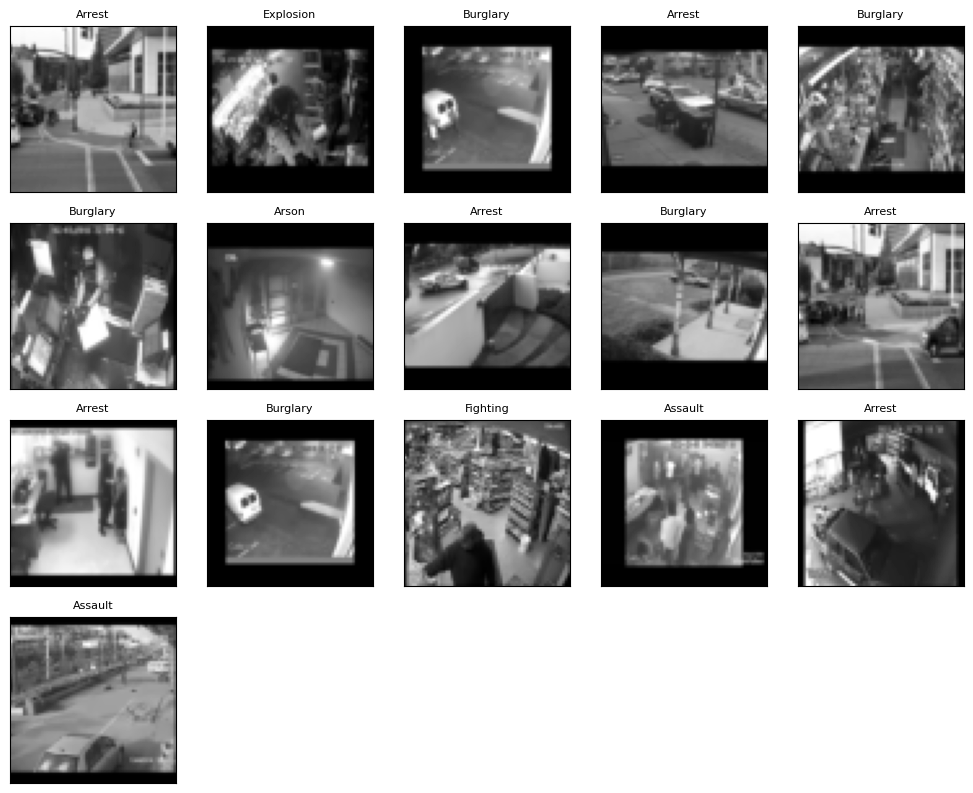

In [9]:
# Cell: Quick Data Check
sample_and_plot(train_ds, n=16)


In [10]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   64, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128,256, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            nn.Flatten(),
            nn.Linear(256 * (RESOLUTION//8)**2, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        return self.net(x)


class LSTMEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1  = nn.LSTM(1, 8, batch_first=True)
        self.lstm2  = nn.LSTM(8, 8, batch_first=True)
        self.fc     = nn.Linear(8, 4)
        self.drop   = nn.Dropout(0.2)

    def forward(self, x):
        B = x.size(0)
        seq = x.view(B, -1, 1)
        out, _ = self.lstm1(seq)
        out, _ = self.lstm2(out)
        return self.drop(self.fc(out[:, -1, :]))


class CrimeClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn  = CNNEncoder()
        self.lstm = LSTMEncoder()
        self.fc   = nn.Linear(256 + 4, num_classes)

    def forward(self, x):
        return self.fc(
            torch.cat([self.cnn(x), self.lstm(x)], dim=1)
        )

# instantiate
num_classes = len(CLASS_PATHS)
model       = nn.DataParallel(CrimeClassifier(num_classes)).to(device)
optimizer   = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion   = nn.CrossEntropyLoss()


In [ ]:
def train_one_epoch():
    model.train()
    for imgs, lbls in tqdm(train_loader, desc="Train"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds      = model(imgs)
        loss       = criterion(preds, lbls)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_accuracy():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds      = model(imgs).argmax(1)
            correct   += (preds == lbls).sum().item()
            total     += lbls.size(0)
    acc = correct / total * 100
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_one_epoch()
    eval_accuracy()

torch.save(model.state_dict(), "crime_model.pt")


Epoch 1/10


Train: 100%|██████████| 102/102 [00:14<00:00,  6.84it/s]


Test Accuracy: 92.54%
Epoch 2/10


Train: 100%|██████████| 102/102 [00:11<00:00,  9.22it/s]


Test Accuracy: 98.04%
Epoch 3/10


Train: 100%|██████████| 102/102 [00:11<00:00,  9.12it/s]


Test Accuracy: 99.16%
Epoch 4/10


Train: 100%|██████████| 102/102 [00:11<00:00,  9.03it/s]


Test Accuracy: 99.29%
Epoch 5/10


Train: 100%|██████████| 102/102 [00:11<00:00,  8.88it/s]


Test Accuracy: 99.63%
Epoch 6/10


Train:  33%|███▎      | 34/102 [00:03<00:07,  8.74it/s]

In [ ]:
from IPython.display import FileLink
FileLink("crime_model.pt")


In [ ]:
from IPython.display import Video
Video("/kaggle/input/fighting/RandomFighting.mp4", embed=True)


In [ ]:
def plot_random_predictions(dataset, model, device, n=25, grid=(5,5)):
    """
    Randomly samples `n` frames from `dataset`, runs them through `model`,
    and displays a grid of images with “true -> pred” labels.
    """
    # Make sure model is in eval mode
    model.eval()
    
    # Label lookup
    labels_map = list(CLASS_PATHS.keys())

    images = []
    titles = []
    with torch.no_grad():
        for _ in range(n):
            idx = torch.randint(0, len(dataset), (1,)).item()
            img, true_lbl = dataset[idx]               # img: Tensor[1,H,W], true_lbl: LongTensor
            images.append(img.squeeze().cpu())
            
            # run through model
            inp   = img.unsqueeze(0).to(device, non_blocking=True)  # [1,1,H,W]
            pred  = model(inp).argmax(dim=1).item()
            
            titles.append(f"{labels_map[true_lbl]} → {labels_map[pred]}")
    
    # display
    plot_frames(images, titles, grid=grid)


In [ ]:
plot_random_predictions(test_ds, model, device, n=25, grid=(5,5))


In [ ]:
from sklearn.metrics import classification_report

# Make sure your model is in eval mode
model.eval()

# Collect all true labels and predictions
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(dim=1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print the classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=list(CLASS_PATHS.keys()),
    digits=4
))
